# Tutorial on Scattering

In this notebook, you will

- Learn what scattering is and why it is important
- Make various ray tracing experiments to validate some theoretical results
- Familiarize yourself with the Sionna RT API
- Visualize the impact of scattering on channel impulse responses and coverage maps

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Scattering Basics](#Scattering-Basics)
* [Scattering Patterns](#Scattering-Patterns)
* [Validation Against the "Far"-Wall Approximation](#Validation-Against-the-\"Far\"-Wall-Approximation)
* [Impact on Channel Impulse Response](#Impact-on-Channel-Impulse-Response)
* [Summary](#Summary)
* [References](#References)

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os # Configure which GPU 
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
            
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
    
from sionna.channel import cir_to_time_channel
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera, LambertianPattern, DirectivePattern, BackscatteringPattern
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

## Scattering Basics

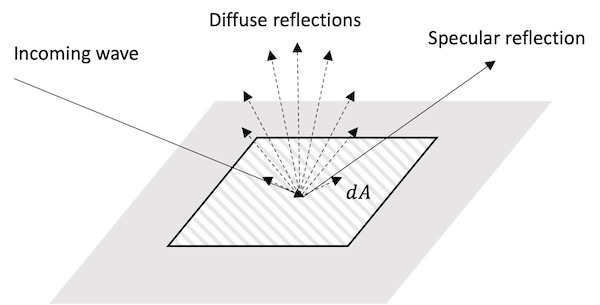


When an electromagnetic wave impinges on a surface, one part of the energy gets reflected while the other part gets refracted, i.e., it propagates into the surface. We distinguish between two types of reflection, specular and diffuse. The latter type is also called diffuse scattering. When a rays hits a diffuse reflection surface, it is not reflected into a single (specular) direction but rather scattered toward many different directions.

One way to think about scattering is that every infinitesimally small surface element $dA$ (as shown in the figure above) reradiates a part of the energy impinging on it. It essentially behaves like a point source that radiates electromagnetic waves into the hemisphere defined by the surface normal [1]. Similar to the far-field of an antenna which is determined by the antenna pattern, the scattered field is determined by the scattering pattern of the surface element, denoted $f_\text{s}(\hat{\mathbf{k}}_\text{i}, \hat{\mathbf{k}}_\text{s})$, where $\hat{\mathbf{k}}_\text{i}$ and $\hat{\mathbf{k}}_\text{s}$ are the incoming and scattered directions, respectively. In other words, the scattered field can be stronger in certain directions than others. 

The most important difference between diffuse and specular reflections for ray tracing is that an incoming ray essentially spawns infinitely many scattered rays while there is only a single specular path. In order to computed the scattered field at a particular position, one needs to integrate the scattered field over the entire surface.

Let us have a look at some common scattering patterns that are implemented in Sionna:

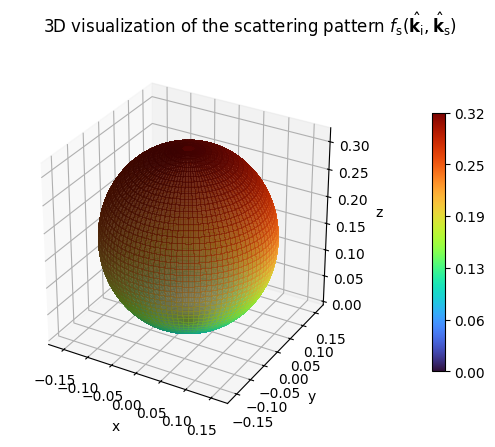

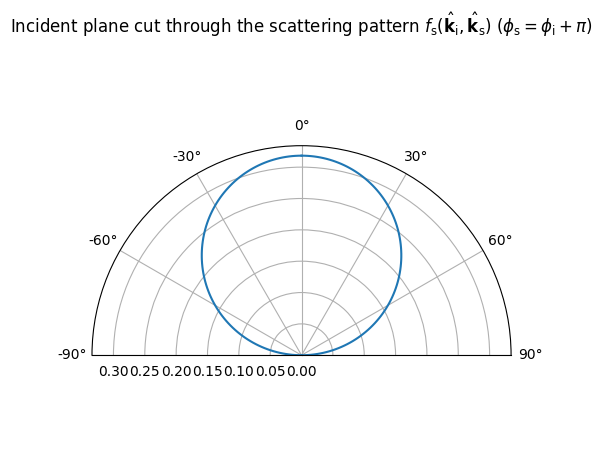

In [2]:
LambertianPattern().visualize();

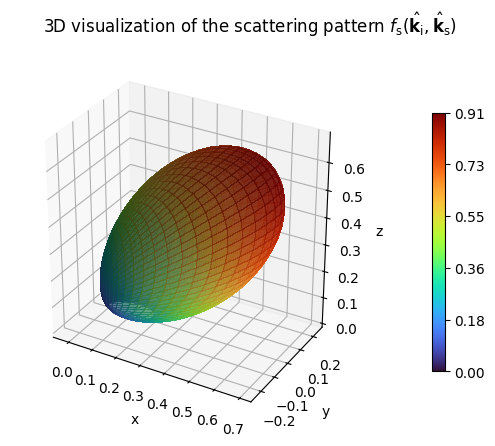

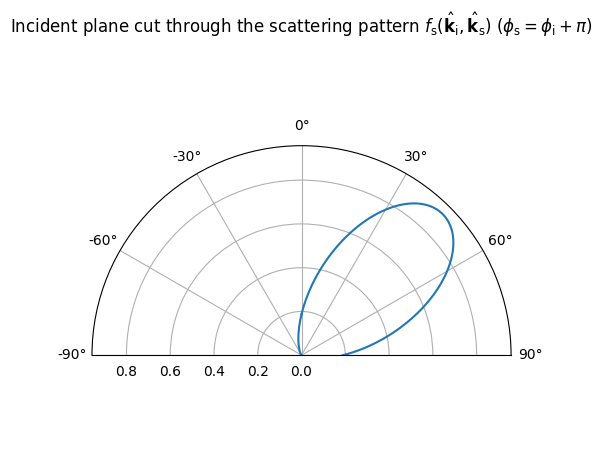

In [3]:
DirectivePattern(alpha_r=10).visualize(); # The stronger alpha_r, the more the pattern
                                          # is concentrated around the specular direction.

In order to develop a feeling for the difference between specular and diffuse reflections, let us load a very simple scene with a single quadratic reflector and place a transmitter and receiver.

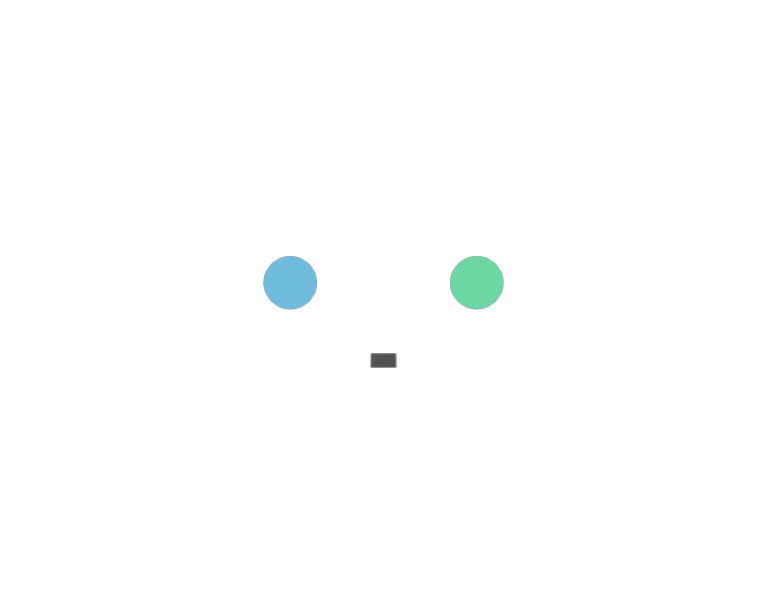

In [4]:
scene = load_scene(sionna.rt.scene.simple_reflector)

# Configure the transmitter and receiver arrays
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

# Add a transmitter and receiver with equal distance from the center of the surface
# at an angle of 45 degrees.
dist = 5
d = dist/np.sqrt(2)
scene.add(Transmitter(name="tx", position=[-d,0,d]))
scene.add(Receiver(name="rx", position=[d,0,d]))

# Add a camera for visualization
scene.add(Camera("my_cam", position=[0, -30, 20], look_at=[0,0,3]))

# Open 3D preview (only works in Jupyter notebook)
if colab_compat:
    scene.render("my_cam");
    raise ExitCell
scene.preview()

Next, let us compute the specularly reflected path:

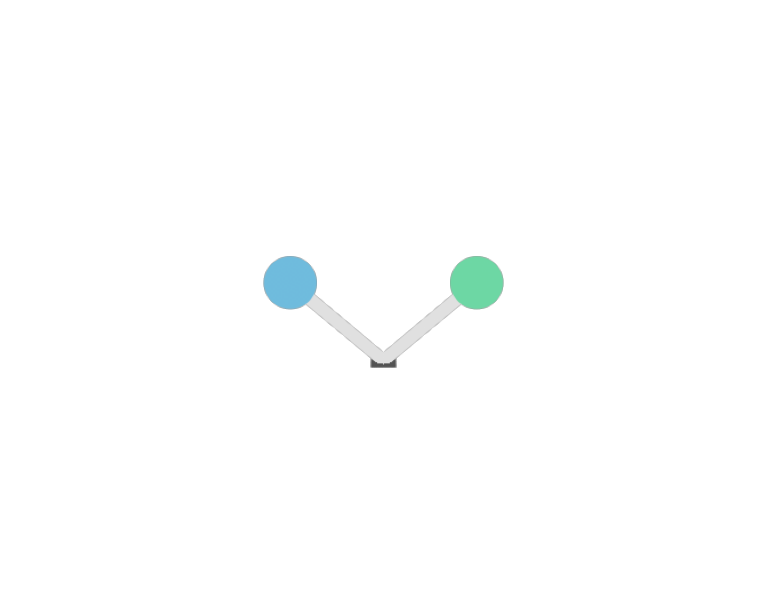

In [5]:
paths = scene.compute_paths(los=False, reflection=True)

# Open 3D preview (only works in Jupyter notebook)
if colab_compat:
    scene.render("my_cam", paths=paths);
    raise ExitCell
scene.preview(paths=paths)

As expected from geometrical optics (GO), the specular path goes through the center of the reflector and has indentical incoming and outgoing angles with the surface normal.

We can compute the scattered paths in a similar way:

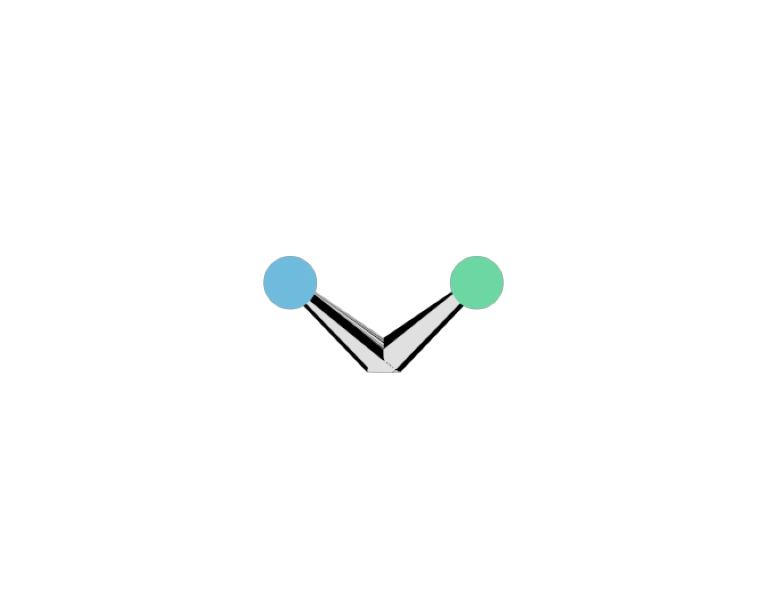

In [6]:
paths = scene.compute_paths(los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
# Open 3D preview (only works in Jupyter notebook)
if colab_compat:
    scene.render("my_cam", paths=paths);
    raise ExitCell
scene.preview(paths=paths)

In [7]:
print(f"There are {tf.size(paths.a).numpy()} scattered paths")

There are 2252 scattered paths


We can see that there is a very large number paths. Actually, any ray that hits the surface will be scattered toward the receiver. Thus, the more rays we shoot, the more scattered paths there are. You can see this through the following experiment:

In [8]:
paths = scene.compute_paths(num_samples=2e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
print(f"There are {tf.size(paths.a).numpy()} scattered paths.")

paths = scene.compute_paths(num_samples=10e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
print(f"There are {tf.size(paths.a).numpy()} scattered paths.")

There are 4506 scattered paths.
There are 22563 scattered paths.


The number of rays hitting the surface is proportional to the total number of rays shot and the squared distance between the transmitter and the surface. However, the total received energy across the surface is constant as the transmitted energy is equally divided between all rays.

If you closely inspect the code in the above cells, you might have noticed the keyword argument `scat_keep_prob`. This determines the fraction of scattered paths that will be randomly dropped in the ray tracing process.  The importance of the remaining paths is increased proportionally. Setting this argument to small values prevents obtaining channel impulse responses with an excessive number of scattered paths.

In [9]:
paths = scene.compute_paths(num_samples=10e6, los=False, reflection=False, scattering=True, scat_keep_prob=0.001)
print(f"There are {tf.size(paths.a).numpy()} scattered paths.")

There are 16 scattered paths.


In our example scene, each ray hitting the surfaces spawns exactly one new ray which connects to the receiver. Each ray has a random phase and energy that is determined by the scattering pattern and the so-called scattering coefficient $S\in[0,1]$. The squared scattering coefficient $S^2$ determines which portion of the totally reflected energy (specular and diffuse combined) is diffusely reflected. For details on the precise modeling of the scattered field, we refer to the [EM Primer](https://nvlabs.github.io/sionna/em_primer.html#scattering).

By default, all materials in Sionna have a scattering coefficient equal to zero. For this reason, we would expect that all of the scattered paths carry zero energy. Let's verify that this is indeed the case:

In [10]:
print("All scattered paths have zero energy:", np.all(np.abs(paths.a)==0))

All scattered paths have zero energy: True


Let us change the scattering coefficient of the radio material used by the reflector and run the path computations again:

In [11]:
scene.get("reflector").radio_material.scattering_coefficient = 0.5
paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True)
print("All scattered paths have positive energy:", np.all(np.abs(paths.a)>0))

All scattered paths have positive energy: True


## Scattering Patterns

In order to study the impact of the scattering pattern, let's replace the perfectly diffuse Lambertian pattern (which all radio materials have by default) by the [DirectivePattern](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.DirectivePattern). The larger the integer parameter $\alpha_r$, the more the scattered field is focused around the direction of the specular reflection.

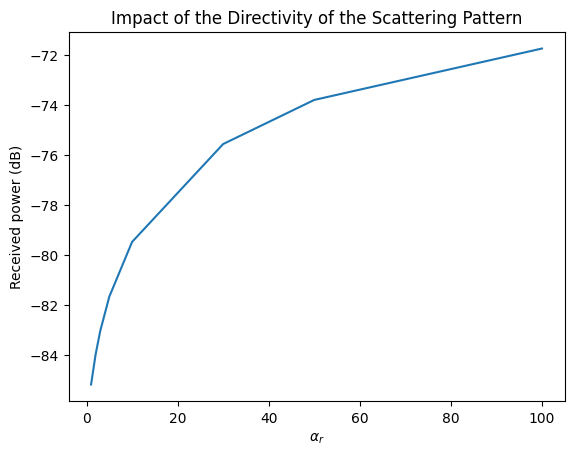

In [12]:
scattering_pattern = DirectivePattern(1)
scene.get("reflector").radio_material.scattering_pattern = scattering_pattern
alpha_rs = np.array([1,2,3,5,10,30,50,100], np.int32)
received_powers = np.zeros_like(alpha_rs, np.float32)
for i, alpha_r in enumerate(alpha_rs):
    scattering_pattern.alpha_r = alpha_r
    paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
    received_powers[i] = 10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))
    
plt.figure()
plt.plot(alpha_rs, received_powers)
plt.xlabel(r"$\alpha_r$")
plt.ylabel("Received power (dB)");
plt.title("Impact of the Directivity of the Scattering Pattern");

We can indeed observe that the received energy increases with $\alpha_r$. This is because the scattered paths are almost parallel to the specular path directions in this scene. If we move the receiver away from the specular direction, this effect should be reversed.

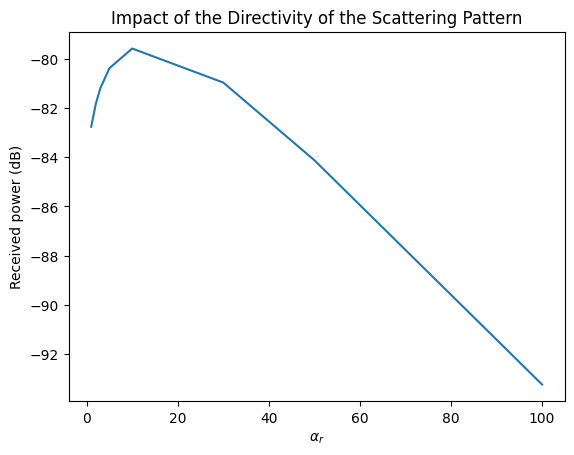

In [13]:
# Move the receiver closer to the surface, i.e., away from the specular angle theta=45deg
scene.get("rx").position = [d, 0, 1]
received_powers = np.zeros_like(alpha_rs, np.float32)
for i, alpha_r in enumerate(alpha_rs):
    scattering_pattern.alpha_r = alpha_r
    paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
    received_powers[i] = 10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))
    
plt.figure()
plt.plot(alpha_rs, received_powers)
plt.xlabel(r"$\alpha_r$")
plt.ylabel("Received power (dB)");
plt.title("Impact of the Directivity of the Scattering Pattern");

## Validation Against the "Far"-Wall Approximation

If the scattering surface is small compared to the distance from its center to the transmitter and receiver, respectively, it can be approximated by a single scattering source that reradiates parts of the energy it has captured by the entire surface $A$. In other words, the scattered field is well approximated by a single ray originating from the barycenter of the surface [2]. The reason for this behavior is that the scattering angle is almost constant for any point on the surface. As described in the [EM Primer](https://nvlabs.github.io/sionna/em_primer.html#scattering), the received power of the scattered path can be computed as

$$ 
P_r = \left(\frac{\lambda S \Gamma}{4\pi r_i r_s}\right)^2 f_\text{s}(\hat{\mathbf{k}}_\text{i}, \hat{\mathbf{k}}_\text{s}) \cos(\theta_i) A
$$

which simplifies for a perfect reflector ($\Gamma=1$) with Lambertian scattering pattern and unit surface area to

$$ 
P_r = \left(\frac{\lambda S}{4\pi r_i r_s}\right)^2 \frac{\cos(\theta_i)\cos(\theta_s)}{\pi}
$$

where $r_i$ and $r_s$ are the distances between the surface center and the transmitter and receiver, respectively. 

We have constructed our scene such that $r_i=r_s$ and $\theta_i=\theta_s=\pi/4$, so that $\cos(\theta_i)=1/\sqrt{2}$.
Thus,

$$
P_r = \left(\frac{\lambda S}{4\pi r_i^2 }\right)^2 \frac{1}{2\pi}
$$

Let's validate for which distances $r_i$ this approximation holds.

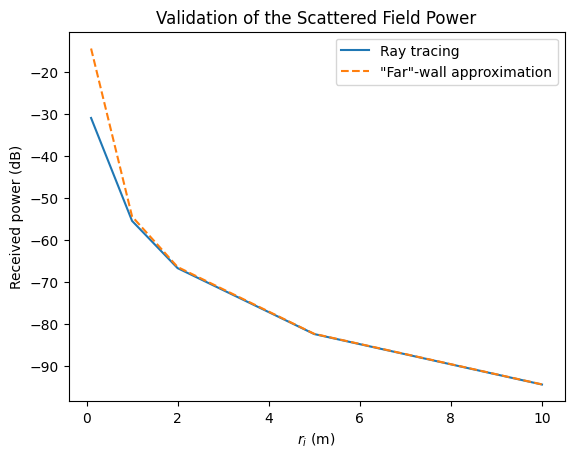

In [14]:
s = 0.7 # Scattering coefficient

# Configure the radio material
scene.get("reflector").radio_material.scattering_pattern = LambertianPattern()
scene.get("reflector").radio_material.scattering_coefficient = s

# Set the carrier frequency
scene.frequency = 3.5e9
wavelength = scene.wavelength

r_is = np.array([0.1, 1, 2, 5, 10], np.float32) # Varying distances
received_powers = np.zeros_like(r_is, np.float32)
theo_powers = np.zeros_like(received_powers)
for i, r_i in enumerate(r_is):
    # Update the positions of TX and RX
    d = r_i/np.sqrt(2)
    scene.get("tx").position = [-d, 0, d]
    scene.get("rx").position = [d, 0, d]
    paths = scene.compute_paths(num_samples=1e6, los=False, reflection=False, scattering=True, scat_keep_prob=1.0)
    received_powers[i] = 10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))
    
    # Compute theoretically received power using the far-wall approximation
    theo_powers[i] = 10*np.log10((wavelength*s/(4*np.pi*r_i**2))**2/(2*np.pi))
    
plt.figure()
plt.plot(r_is, received_powers)
plt.plot(r_is, theo_powers, "--")
plt.title("Validation of the Scattered Field Power")
plt.xlabel(r"$r_i$ (m)")
plt.ylabel("Received power (dB)");
plt.legend(["Ray tracing", "\"Far\"-wall approximation"]);

We can observe an almost perfect match between the results for ray-tracing and the "far"-wall approximation from a distance of $2\,$m on. For smaller distances, there is a significant (but expected) difference. In general, none of both approaches is valid for very short propagation distances.

## Coverage Maps With Scattering

By now, you have a gained a solid understanding of scattering from a single surface. Let us now make things a bit more interesting by looking at a complex scene with many scattering surfaces. This can be nicely observed with the help of coverage maps. 

A coverage map describes the average received power from a specific transmitter at every point on a plane. The effects of fast fading, i.e., constructive/destructive interference between different paths, are averaged out by summing the squared amplitudes of all paths. As we cannot compute coverage maps with infinitely fine resolution, they are approximated by small rectangular tiles for which average values are computed. For a detailed explanation, have a look at the [API Documentation](https://nvlabs.github.io/sionna/api/rt.html#coverage-map).

Let us now load a slightly more interesting scene containing a couple of rectangular buildings and add a transmitter. Note that we do not need to add any receivers to compute a coverage map (we will add one though as we need it later).

In [15]:
scene = load_scene(sionna.rt.scene.simple_street_canyon)

scene.frequency = 30e9
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array
scene.add(Transmitter(name="tx",
                      position=[-33,11,32],
                      orientation=[0,0,0]))

# We add a receiver for later path computations
scene.add(Receiver(name="rx",
                      position=[27,-13,1.5],
                      orientation=[0,0,0]))

my_cam = Camera("my_cam", position=[10,0,300], look_at=[0,0,0])
my_cam.look_at([0,0,0])
scene.add(my_cam)

Computing and visualizing a coverage map is as simple as running the following commands:

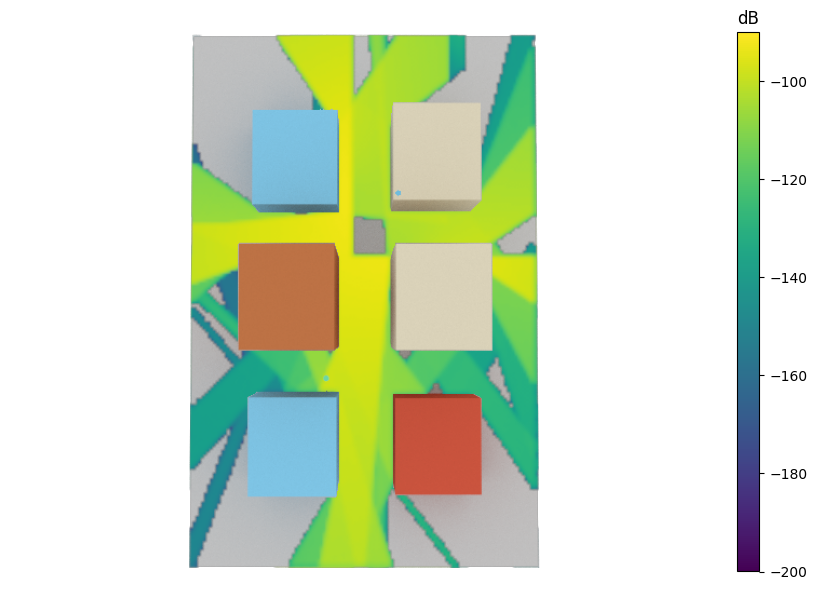

In [16]:
cm = scene.coverage_map(cm_cell_size=[1,1], num_samples=20e6, max_depth=5)
scene.render(my_cam, coverage_map=cm, cm_vmin=-200, cm_vmax=-90);

By default, coverage maps are only computed for line-of-sight and specular reflections. The parameter ``cm_cell_size`` determines the resolution of the coverage map. However, the finer the resolution, the more rays (i.e., `num_samples`) must be shot. We can see from the above figure, that there are various regions which have no coverage as they cannot be reached by purely reflected paths. 

Let's now enable diffuse reflections and see what happens.

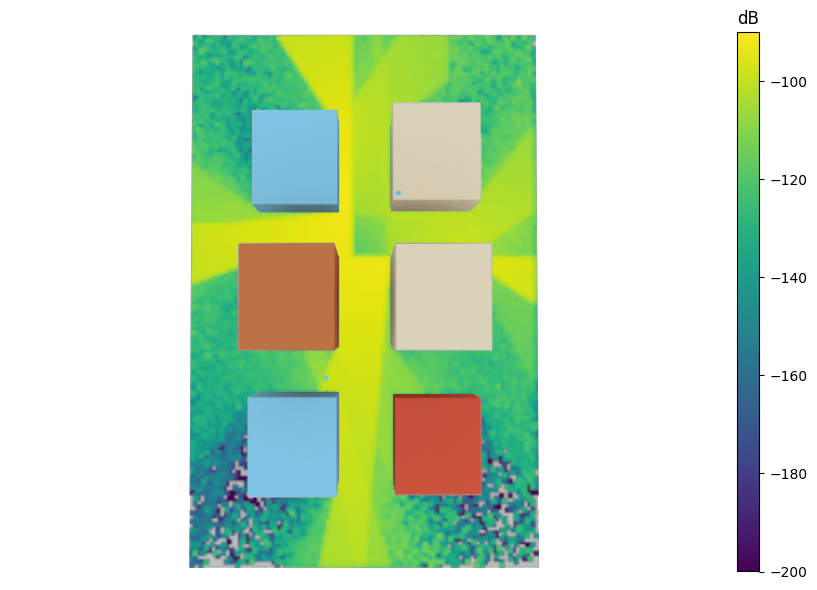

In [17]:
# Configure radio materials for scattering
# By default the scattering coefficient is set to zero
for rm in scene.radio_materials.values():
    rm.scattering_coefficient = 1/np.sqrt(3) # Try different values in [0,1]
    rm.scattering_pattern = DirectivePattern(alpha_r=10) # Play around with different values of alpha_r

cm_scat = scene.coverage_map(cm_cell_size=[1,1], num_samples=20e6, max_depth=5, scattering=True)
scene.render(my_cam, coverage_map=cm_scat, cm_vmin=-200, cm_vmax=-90);

Thanks to scattering, most regions in the scene have some coverage. However, the scattered field is weak compared to that of the LoS and reflected paths. Also note that the peak signal strength has slightly decreased. This is because the scattering coefficient takes away some of the specularly reflected energy.

## Impact on Channel Impulse Response

As a last experiment in our tutorial on scattering, let us have a look at the discrete baseband-equivalent channel impulse responses we obtain with and without scattering. To this end, we will compute the channel impulse response of the  single receiver we have configured for the current scene, and then transform it into the complex baseband representation using the convenience function [cir_to_time_channel](https://nvlabs.github.io/sionna/api/channel.wireless.html#cir-to-time-channel).

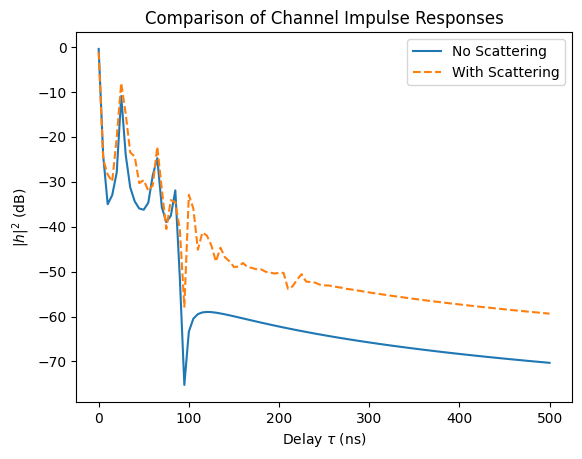

In [18]:
# Change the scattering coefficient of all radio materials
for rm in scene.radio_materials.values():
    rm.scattering_coefficient = 1/np.sqrt(3)
    
bandwidth=200e6 # bandwidth of the receiver (= sampling frequency)
    
plt.figure()
tf.random.set_seed(20)
paths = scene.compute_paths(max_depth=5,
                            num_samples=20e6,
                            scattering=True)

# Compute time channel without scattering
h = np.squeeze(cir_to_time_channel(bandwidth, *paths.cir(scattering=False), 0, 100, normalize=True))
tau = np.arange(h.shape[0])/bandwidth*1e9
plt.plot(tau, 20*np.log10(np.abs(h)));

# Compute time channel with scattering
h = np.squeeze(cir_to_time_channel(bandwidth, *paths.cir(), 0, 100, normalize=True))
plt.plot(tau, 20*np.log10(np.abs(h)), "--");
plt.xlabel(r"Delay $\tau$ (ns)")
plt.ylabel(r"$|h|^2$ (dB)");
plt.title("Comparison of Channel Impulse Responses")
plt.legend(["No Scattering", "With Scattering"]);

The discrete channel impulse response looks similar for small values of $\tau$, where the field is dominated by strong LOS and reflected paths. However, in the middle and tail, there are differences of a few dB which can have a significant impact on the link-level performance.

## Summary

In conclusion, scattering plays an important role for radio propagation modelling. In particular, the higher the carrier frequency, the rougher most surfaces appear compared to the wavelength. Thus, at THz-frequencies diffuse reflections might become the dominating form of radio wave propgation (apart from LoS).

We hope you enjoyed our dive into scattering with this Sionna RT tutorial. Please try out some experiments yourself and improve your grasp of ray tracing. There's more to discover, so so don't forget to check out our other [tutorials](https://nvlabs.github.io/sionna/tutorials.html), too.

## References
[1] Vittorio Degli-Esposti et al., [Measurement and modelling of scattering from buildings](https://ieeexplore.ieee.org/abstract/document/4052607), IEEE Trans. Antennas Propag., vol. 55, no. 1,  pp.143-153, Jan. 2007.

[2] Vittorio Degli-Esposti et al., [An advanced field prediction model including diffuse scattering](https://ieeexplore.ieee.org/abstract/document/1310631), IEEE Trans. Antennas Propag., vol. 52, no. 7, pp.1717-1728, Jul. 2004.